In [1]:
import numpy as np
from datetime import datetime, timedelta
from pyproj import Proj
import xarray
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import sys

import metpy

sys.path.append('/pyBKB_v3')
'''
from BB_GOES.get_GOES import get_GOES_nearesttime

DATE = datetime(2019, 4, 17, 15)

# This functin gets the nearest file name and path on our local disk. 
# You might want to download GOES files from Amazon.
file16 = get_GOES_nearesttime(DATE, product='ABI', satellite=16, verbose=False)
file17 = get_GOES_nearesttime(DATE, product='ABI', satellite=17, verbose=False)
'''
G16 = xarray.open_dataset('OR_ABI-L2-MCMIPC-M6_G16_s20191771701200_e20191771703573_c20191771704096.nc')
G17 = xarray.open_dataset('OR_ABI-L2-MCMIPC-M6_G17_s20191771701197_e20191771703570_c20191771704070.nc')


In [3]:
print(G16['CMI_C02'])

<xarray.DataArray 'CMI_C02' (y: 1500, x: 2500)>
array([[     nan,      nan,      nan, ..., 0.045079, 0.044444, 0.044444],
       [     nan,      nan,      nan, ..., 0.044762, 0.044127, 0.044762],
       [     nan,      nan,      nan, ..., 0.045079, 0.044127, 0.044444],
       ...,
       [0.577777, 0.549841, 0.547619, ..., 0.068254, 0.066984, 0.067302],
       [0.610476, 0.586031, 0.541587, ..., 0.069206, 0.068254, 0.067619],
       [0.586666, 0.593333, 0.554285, ..., 0.073333, 0.069841, 0.067619]],
      dtype=float32)
Coordinates:
    t        datetime64[ns] ...
  * y        (y) float32 0.128212 0.128156 ... 0.044324003 0.044268005
  * x        (x) float32 -0.101332 -0.101276 ... 0.038556002 0.038612
    y_image  float32 ...
    x_image  float32 ...
Attributes:
    long_name:              ABI Cloud and Moisture Imagery reflectance factor
    standard_name:          toa_lambertian_equivalent_albedo_multiplied_by_co...
    sensor_band_bit_depth:  12
    downsampling_method:    average


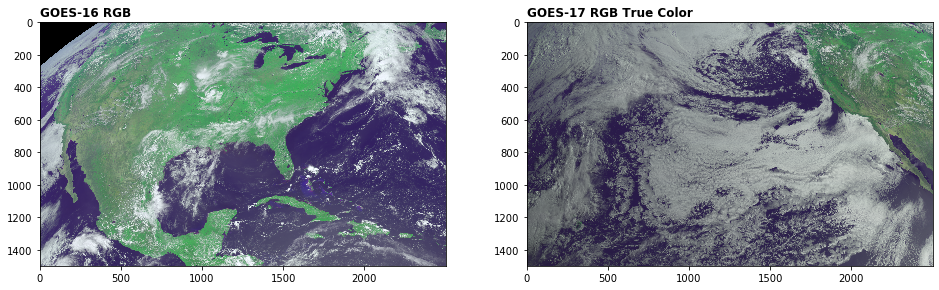

In [3]:
R_16 = G16['CMI_C02'].data
G_16 = G16['CMI_C03'].data
B_16 = G16['CMI_C01'].data
R_17 = G17['CMI_C02'].data
G_17 = G17['CMI_C03'].data
B_17 = G17['CMI_C01'].data


R_16 = np.clip(R_16, 0, 1)
G_16 = np.clip(G_16, 0, 1)
B_16 = np.clip(B_16, 0, 1)
R_17 = np.clip(R_17, 0, 1)
G_17 = np.clip(G_17, 0, 1)
B_17 = np.clip(B_17, 0, 1)

gamma = 2.2
R_16 = np.power(R_16, 1/gamma)
G_16 = np.power(G_16, 1/gamma)
B_16 = np.power(B_16, 1/gamma)
R_17 = np.power(R_17, 1/gamma)
G_17 = np.power(G_17, 1/gamma)
B_17 = np.power(B_17, 1/gamma)

RGB_16 = np.dstack([R_16, G_16, B_16])#making the 3D array [,,]
RGB_17 = np.dstack([R_17, G_17, B_17])#making the 3D array [,,]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))

ax1.imshow(RGB_16)
ax1.set_title('GOES-16 RGB', fontweight='semibold', loc='left', fontsize=12);

ax2.imshow(RGB_17)
ax2.set_title('GOES-17 RGB True Color', fontweight='semibold', loc='left', fontsize=12);


In [4]:
# Generate cartopy projection object with metpy parser
# NOTE: Don't re-run this cell after it has run or it won't work.
dat16 = G16.metpy.parse_cf('CMI_C02')
dat17 = G17.metpy.parse_cf('CMI_C02')

# Geostationary projections
geos16 = dat16.metpy.cartopy_crs
geos17 = dat17.metpy.cartopy_crs

/home/adomakor412/.conda/envs/GOESCode/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)
/home/adomakor412/.conda/envs/GOESCode/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


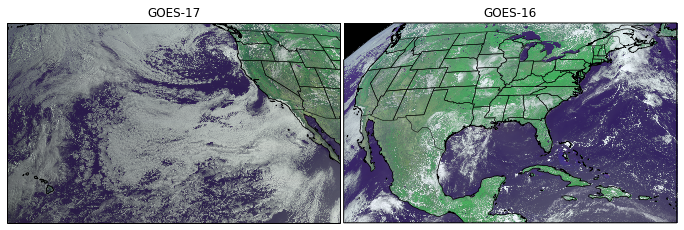

In [5]:
x16 = dat16.x
y16 = dat16.y

x17 = dat17.x
y17 = dat17.y
pc = ccrs.PlateCarree()

fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1, projection=geos17)
ax2 = fig.add_subplot(1, 2, 2, projection=geos16)

## GOES 17
ax1.imshow(RGB_17, origin='upper', extent=(x17.min(), x17.max(), y17.min(), y17.max()),
           transform=geos17)
ax1.coastlines(resolution='50m', color='black', linewidth=.75)
ax1.add_feature(ccrs.cartopy.feature.STATES, linewidth=.5)
ax1.set_title('GOES-17')

## GOES 16
ax2.imshow(RGB_16, origin='upper', extent=(x16.min(), x16.max(), y16.min(), y16.max()),
           transform=geos16)
ax2.coastlines(resolution='50m', color='black', linewidth=.75)
ax2.add_feature(ccrs.cartopy.feature.STATES, linewidth=.5)
ax2.set_title('GOES-16')

fig.subplots_adjust(wspace=.01)

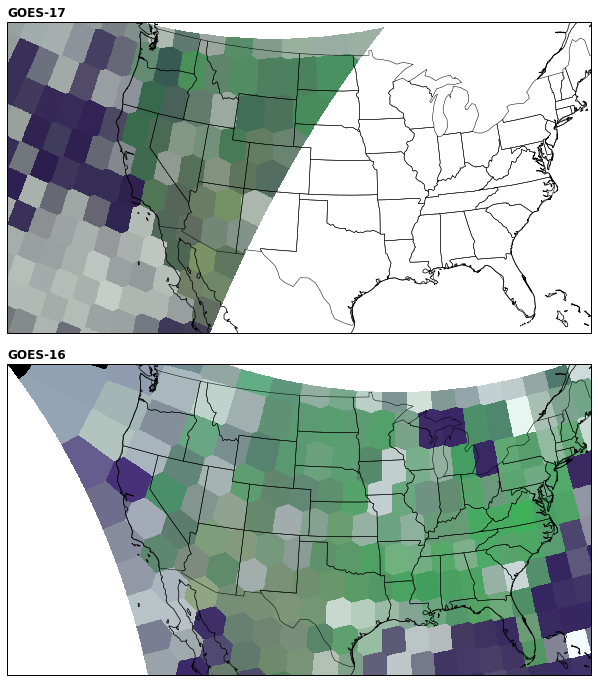

In [8]:
#Downsampling the image makes it faster to plot large areas
thin = 100


fig = plt.figure(figsize=[12, 12])


lc = ccrs.LambertConformal(central_longitude = -97.5,
                           standard_parallels = (38.5, 38.5))

ax1 = fig.add_subplot(2, 1, 1, projection=lc)
ax2 = fig.add_subplot(2, 1, 2, projection=lc)

ax1.set_extent([-130, -75, 25, 48], crs=pc)
ax2.set_extent([-130, -75, 25, 48], crs=pc)

#ax1.set_extent([-155, -70, 20, 45], crs=pc)
#ax1.set_extent([-122.72, -72.29, 24.36, 50.45], crs=pc) # HRRR


# GOES17
ax1.imshow(RGB_17[::thin,::thin], origin='upper',
           extent=(x17.min(), x17.max(), y17.min(), y17.max()),
           transform=geos17, 
           interpolation='none')

ax1.coastlines(resolution='50m', color='black', linewidth=0.75)
ax1.add_feature(ccrs.cartopy.feature.STATES, linewidth=0.5)
ax1.set_title('GOES-17', loc='left', fontweight='bold')


# GOES16
# The imshow transform seems to take a long time
ax2.imshow(RGB_16[::thin,::thin], origin='upper',
           extent=(x16.min(), x16.max(), y16.min(), y16.max()),
           transform=geos16,
           interpolation='none')

ax2.coastlines(resolution='50m', color='black', linewidth=0.75)
ax2.add_feature(ccrs.cartopy.feature.STATES, linewidth=0.5)
ax2.set_title('GOES-16', loc='left', fontweight='bold')


fig.subplots_adjust(hspace=.1)

thin:  2
0:00:05.356327
0:00:10.752290


Text(0.5, 1.0, 'GOES-17 Overlaid on GOES-16')

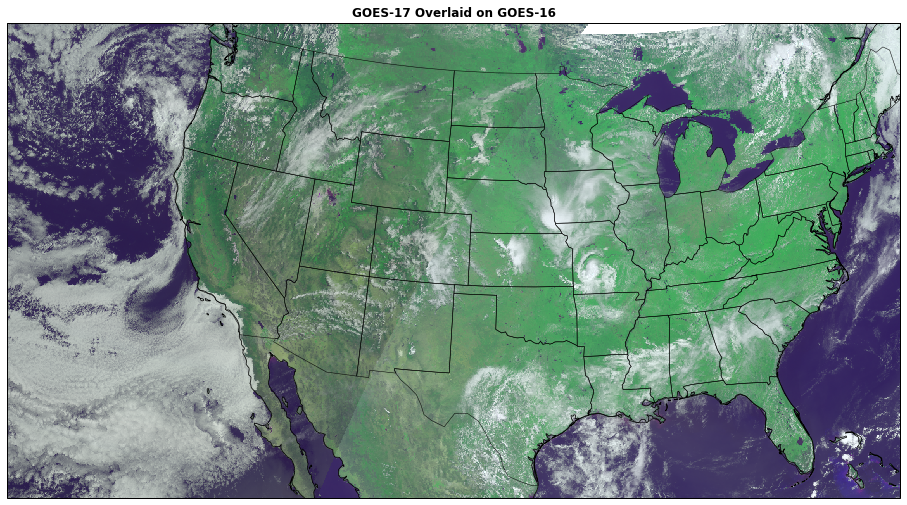

In [9]:
# Downsampling the image makes it faster to plot large areas
thin = 2
print("thin: ", thin)

fig = plt.figure(figsize=[16, 12])


lc = ccrs.LambertConformal(central_longitude = -97.5,
                           standard_parallels = (38.5, 38.5))

ax3 = fig.add_subplot(1, 1, 1, projection=lc)
ax3.set_extent([-130, -75, 25, 48], crs=pc)

# GOES16 + GOES17

# The imshow transform seems to take a long time
timer = datetime.now()
ax3.imshow(RGB_16[::thin,::thin], origin='upper',
           extent=(x16.min(), x16.max(), y16.min(), y16.max()),
           transform=geos16,
           interpolation='none')
print(datetime.now()-timer)

ax3.imshow(RGB_17[::thin,::thin], origin='upper',
           extent=(x17.min(), x17.max(), y17.min(), y17.max()),
           transform=geos17,
           interpolation='none')
print(datetime.now()-timer)

ax3.coastlines(resolution='50m', color='black', linewidth=0.75)
ax3.add_feature(ccrs.cartopy.feature.STATES, linewidth=0.5)

plt.title('GOES-17 Overlaid on GOES-16', fontweight='bold')

In [10]:
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt
# lon_0 is the central longitude of the projection.
# resolution = 'l' means use low resolution coastlines.
# optional parameter 'satellite_height' may be used to
# specify height of orbit above earth (default 35,786 km).
m = Basemap(projection='geos',lon_0=-105,resolution='l')
m.drawcoastlines()
m.fillcontinents(color='coral',lake_color='aqua')
# draw parallels and meridians.
m.drawparallels(np.arange(-90.,120.,30.))
m.drawmeridians(np.arange(0.,420.,60.))
m.drawmapboundary(fill_color='aqua')
plt.title("Full Disk Geostationary Projection")
plt.show()

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

In [1]:
from pyresample import image, geometry

ModuleNotFoundError: No module named 'pyresample'

In [4]:
!conda install -c conda-forge pyresample -y

Solving environment: done

## Package Plan ##

  environment location: /home/adomakor412/.conda/envs/GOESCode

  added / updated specs:
    - pyresample


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.6.16          |           py37_0         148 KB  conda-forge
    configobj-5.0.6            |             py_0          31 KB  conda-forge
    pyresample-1.12.3          |   py37hf2d7682_0         465 KB  conda-forge
    pyyaml-5.1.1               |   py37h516909a_0         184 KB  conda-forge
    yaml-0.1.7                 |    h14c3975_1001          78 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         906 KB

The following NEW packages will be INSTALLED:

  configobj          conda-forge/noarch::configobj-5.0.6-py_0
  pyresample         conda-forge/linux-64::pyresample-1.12.3-py37hf2d76

In [5]:
from pyresample import image, geometry
